- 이 자료는 핸즈온 머신러닝 책 & 코드와 고려대학교 강필성 교수님 강의를 공부한 내용입니다.

## SetUp

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 7.5 부스팅 (boosting)

**부스팅**(boosting)은 성능이 약한 학습기(weak learner)를 여러 개 연결하여 강한 학습기(strong learner)를 만드는 앙상블 학습이다. 부스팅 방법의 아이디어는 앞에서 학습된 모델을 보완해나가면서 더나은 모델로 학습시키는 것이다. 부스팅 방법에는 여러 종류가 있는데, 그 중 가장 유명하고 인기 있는 모델은 **아다부스트**(AdaBoost, Adaptive Boosting)와 **그래디언트 부스팅**(Gradient Boosting) 두 가지가 있다.

### 7.5.1 아다부스트 (AdaBoost)

아다부스트(AdaBoost)는 과소적합(underfitted)됐던 학습 데이터 샘플의 가중치를 높이면서 새로 학습된 모델이 학습하기 어려운 데이터에 더 잘 적합되도록 하는 방식이다. 아래의 그림에서 처럼 아다부스트의 단계를 설명하면 다음과 같다.

1. 먼저 전제 학습 데이터셋을 이용해 모델을 만든 후, 잘못 예측(분류)된 샘플의 가중치를 상대적으로 높여준다. 
2. 그 다음 두 번째 모델을 학습 시킬때 이렇게 업데이트된 가중치를 반영하여 모델을 학습 시킨다. 
3. 이와 같은 과정을 반복한다.



![](./img/adaboost.png)

## Boosting: AdaBoost 예제 과정

![](./img/adaboost_ex1.png)

![](./img/adaboost_ex2.png)

- y는 True 클래스, h(x)는 예상 결과
- y==h(x)이면, 정답이므로 뽑힐 확률이 비교적 틀린 클래스에 비해 줄어듬
- 틀린 예측에 대한 클래스가 뽑힐 확률을 높힘

![](./img/adaboost_ex3.png)

![](./img/adaboost_ex4.png)

![](./img/adaboost_ex5.png)

#### moons 데이터셋에 AdaBoost 적용하기

Scikit-Learn에는 AdaBoost를 사용할 수 있도록 [`AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)를 제공한다. 

아래의 예제는 `moons`데이터셋에 `AdaBoostClassifier` 모델을 학습시킨 것이다. 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [4]:
from sklearn.metrics import accuracy_score

y_pred = ada_clf.predict(X_test)
print(ada_clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.896


In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

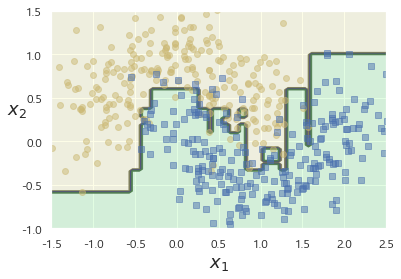

In [6]:
plot_decision_boundary(ada_clf, X, y)

## 아래는 참고~~~

#### AdaBoost 알고리즘

AdaBoost의 논문인 [*A Short Introduction to Boosting*](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf)에서 AdaBoost 알고리즘은 다음과 같다.

<img src="./img/adaboost03.png" height="75%" width="75%"/>

위의 알고리즘을 각 단계별로 살펴보자. 

① 먼저 각 데이터의 가중치 $w_i$는 $\frac{1}{m}$으로 초기화한다.

$t = 1, \dots, T$ 까지 반복하는데, 

② 모델이 학습되고, 가중치가 적용된 에러율(weighted error rate)을 계산한다.

$$
\epsilon_t = \frac{\underset{ h_{t}(x_i) \neq y_i }{ \sum_{i=1}^{m}{w_i} } }{\sum_{i=1}^{m}{w_i}}
$$

- $h_{t}(x_i)$는 $i$-번째 데이터에 대한 $t$-번째 모델의 예측값이다.
- 위의 식은 $t$-번째 모델에서 실제값과 예측값이 같지 않은($ h_{t}(x_i) \neq y_i$) 샘플의 가중치($w_i$)의 합에서 전체 가중치의 합으로 나눈 비율을 에러율($\epsilon_t$)라고 정의한 것이다.

③ 각 $t$-번째 모델에 대한 가중치 $\alpha_t$는 다음과 같다.

$$
\alpha_t = \eta \log{\frac{1 - \epsilon_t}{\epsilon_t}}
$$

- $\eta$는 학습률(learning rate)을 의미하며, 논문에서는 학습률은 사용하지 않지만, scikit-learn의 [`AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)에서는 `learning_rate`의 인자가 있으며, 기본값은 `1`이다. 

④ 그런 다음, 아래의 식을 통해 가중치($w_i$)를 업데이트 해준다.

$$
W_{t+1} = \frac{W_t(i) \exp{\left( - \alpha_t y_i h_t \left(x_i \right) \right)}}{Z_t}
$$

- $Z_t$는 정규화 인자이며, $t$-번째 모델에서 모든 데이터의 가중치를 정규화 해준다($\sum_{i=1}^{m}{w_i}$로 나눠준다).

⑤ 학습이 끝난 후 최종 결과는 $T$개의 weak learner를 **weighted linear combination**(가중치 선형결합)을 하여 strong learner $H(x)$를 구하여 값을 예측한다.

$$
H(\mathbf{x}) = \alpha_1 h_1(\mathbf{x}) + \cdots + \alpha_{T} h_{T}(\mathbf{x}) = \sum_{t=1}^{T}{\alpha_t h_t(\mathbf{x})}
$$


#### Scikit-Learn에서 AdaBoost 알고리즘

Scikit-Learn의 `AdaBoostClassifier`에서는 **SAMME**(Stagewise Additive using a Multiclass Exponential loss function)과 **SAMME.R**(R은 Real을 의미)이라는 **Multi-Class AdaBoost**를 사용(default는 `algorithm='SAMME.R'`)한다. SAMME 알고리즘은 위의 AdaBoost 알고리즘과 거의 동일하며, $t$-번째 모델에 대한 가중치를 계산하는 부분인 ③에서의 식이 아래와 같이 다르다.

$$
\alpha_t = \eta \left( \log{\frac{1-\epsilon_t}{\epsilon_t}} + \log{(K-1)} \right)
$$

- $K$는 클래스(레이블)을 의미하며 2일 경우, 즉 이진분류일 경우에는 위의 AdaBoost와 동일한 알고리즘이 된다. 

**SAMME.R**은 각 모델의 예측값이 아닌 soft voting 처럼 예측 클래스의 확률을 이용해, $t$-번째 모델에 대한 가중치(③부분)를 계산하는 알고리즘이다.

$$
\alpha_t = -\eta \frac{K-1}{K} y \log{\hat{y}_t}
$$

- $y$는 예측한 클래스와 실제 클래스가 일치(정답)할 경우에는 $1$, 그렇지 않으면 $-\frac{1}{1-K}$이다.
- $\hat{y}_t$는 $t$-번째 모델이 예측한 클래스의 확률이며 식은 다음과 같다.

$$
\hat{y}(x) = \underset{k}{\text{argmax}} \sum_{t=1}^{T}{(K-1)\left( \log{\hat{y}_t} - \frac{1}{K} \sum_{k=0}^{K}{\hat{y}_t} \right)}
$$